In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

In [36]:
data = pd.read_csv('/content/TrafficTwoMonth.csv')

In [37]:
data.head()

Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        13          2         2   
1  12:15:00 AM    10         Tuesday        14          1         1   
2  12:30:00 AM    10         Tuesday        10          2         2   
3  12:45:00 AM    10         Tuesday        10          2         2   
4   1:00:00 AM    10         Tuesday        11          2         1   

   TruckCount  Total Traffic Situation  
0          24     41            normal  
1          36     52            normal  
2          32     46            normal  
3          36     50            normal  
4          34     48            normal

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               5952 non-null   object
 1   Date               5952 non-null   int64 
 2   Day of the week    5952 non-null   object
 3   CarCount           5952 non-null   int64 
 4   BikeCount          5952 non-null   int64 
 5   BusCount           5952 non-null   int64 
 6   TruckCount         5952 non-null   int64 
 7   Total              5952 non-null   int64 
 8   Traffic Situation  5952 non-null   object
dtypes: int64(6), object(3)
memory usage: 418.6+ KB


In [39]:
data.describe()

Date     CarCount    BikeCount     BusCount   TruckCount  \
count  5952.000000  5952.000000  5952.000000  5952.000000  5952.000000   
mean     16.000000    65.440692    12.161458    12.912970    18.646337   
std       8.945023    44.749335    11.537944    12.497736    10.973139   
min       1.000000     5.000000     0.000000     0.000000     0.000000   
25%       8.000000    18.750000     3.000000     2.000000    10.000000   
50%      16.000000    62.000000     9.000000    10.000000    18.000000   
75%      24.000000   103.000000    19.000000    20.000000    27.000000   
max      31.000000   180.000000    70.000000    50.000000    60.000000   

             Total  
count  5952.000000  
mean    109.161458  
std      55.996312  
min      21.000000  
25%      54.000000  
50%     104.000000  
75%     153.000000  
max     279.000000

In [40]:
data.isnull().sum()

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

# Exploratory Data Analysis üìà

<Axes: xlabel='Day of the week', ylabel='Count'>

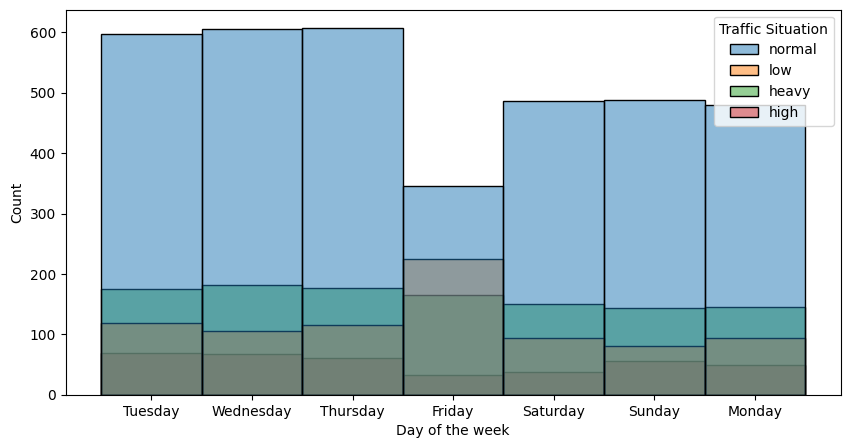

In [41]:
#['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       #'TruckCount', 'Total', 'Traffic Situation']
plt.figure(figsize=(10,5))
sns.histplot(data=data, x="Day of the week", hue="Traffic Situation")

<Axes: xlabel='Date', ylabel='Count'>

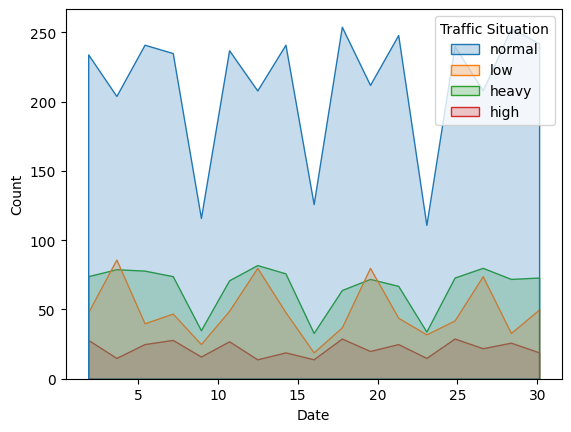

In [42]:
sns.histplot(data, x="Date", hue="Traffic Situation", element="poly")

<Axes: xlabel='Total', ylabel='Count'>

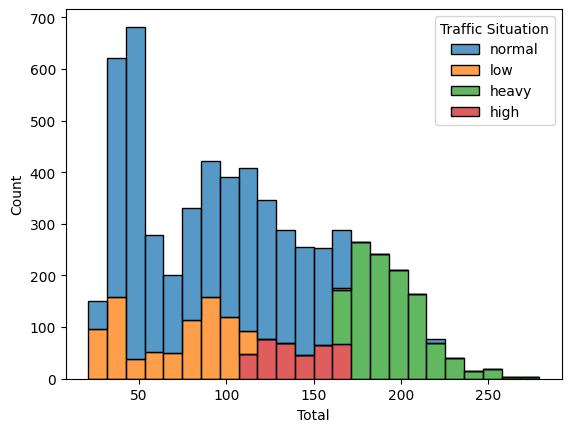

In [43]:
sns.histplot(data=data, x="Total", hue="Traffic Situation", multiple="stack")

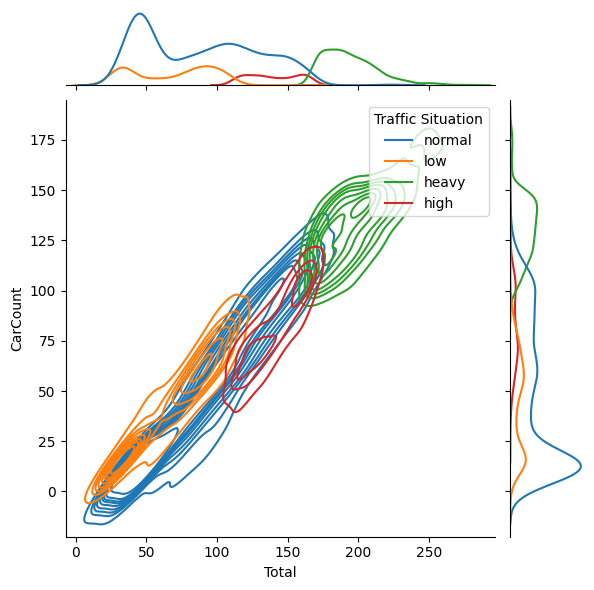

In [44]:
sns.jointplot(data=data, x="Total", y="CarCount", hue="Traffic Situation", kind="kde")

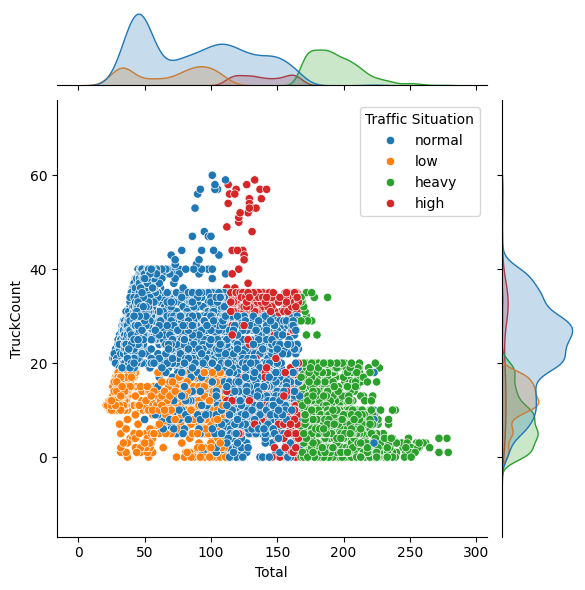

In [45]:
sns.jointplot(data=data, x="Total", y="TruckCount",
              hue="Traffic Situation")

# Feature Engineering üõ†‚öôÔ∏è

In [46]:
data.columns

Index(['Time', 'Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation'],
      dtype='object')

In [47]:
# Distinct Classes in Target variable
data['Traffic Situation'].value_counts()

Traffic Situation
normal    3610
heavy     1137
low        834
high       371
Name: count, dtype: int64

We have 04 distinct Classes

In [48]:
#Converting target variable 'Traffic Situation' into Numeric form
data['Traffic Situation'] = data['Traffic Situation'].replace({'low':0, 'normal':1,
                                                              'heavy':2, 'high':3})

<ipython-input-48-e3ba9a60f53e>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Traffic Situation'] = data['Traffic Situation'].replace({'low':0, 'normal':1,


In [49]:
#Dealing with 'Day of the week' feature
data['Day of the week'].value_counts()

Day of the week
Tuesday      960
Wednesday    960
Thursday     960
Friday       768
Saturday     768
Sunday       768
Monday       768
Name: count, dtype: int64

In [50]:
#Converting Days of weak into Numeric form
data['Day of the week'] = data['Day of the week'].replace({'Monday':1,'Tuesday':2,
                                                          'Wednesday':3,'Thursday':4,
                                                          'Friday':5,'Saturday':6,
                                                          'Sunday':7})

<ipython-input-50-21a930fc2358>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Day of the week'] = data['Day of the week'].replace({'Monday':1,'Tuesday':2,


In [51]:
test_temp = data.copy()

In [52]:
#Extracting Specific time-related information from 'Time(24:00 am/pm)' column

data['hour'] = pd.to_datetime(data['Time']).dt.hour #Hour in separate column
data['minute'] = pd.to_datetime(data['Time']).dt.minute #Minute in separate column


# replace 0 with AM
# replace 1 with PM

data['Temp'] = data['Time'].apply(lambda x: x.split(' ')[1]) #Temporary column for AM/PM
data['AM/PM'] = data['Temp'].replace({'AM':0,'PM':1})

<ipython-input-52-db31c400f9e7>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['hour'] = pd.to_datetime(data['Time']).dt.hour #Hour in separate column
<ipython-input-52-db31c400f9e7>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['minute'] = pd.to_datetime(data['Time']).dt.minute #Minute in separate column
<ipython-input-52-db31c400f9e7>:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['AM/PM'] = data['Temp'].replace({'AM':0,'PM':1})


In [53]:
#Now remove 'Temp' and 'Time' columns
data= data.drop(columns = ['Time','Temp'], axis=1)
data

Date  Day of the week  CarCount  BikeCount  BusCount  TruckCount  Total  \
0       10                2        13          2         2          24     41   
1       10                2        14          1         1          36     52   
2       10                2        10          2         2          32     46   
3       10                2        10          2         2          36     50   
4       10                2        11          2         1          34     48   
...    ...              ...       ...        ...       ...         ...    ...   
5947     9                4        16          3         1          36     56   
5948     9                4        11          0         1          30     42   
5949     9                4        15          4         1          25     45   
5950     9                4        16          5         0          27     48   
5951     9                4        14          3         1          15     33   

      Traffic Situation  hour  minute  AM/PM  
0                     1     0       0      0  
1                     1     0      15      0  
2                     1     0      30      0  
3                     1     0      45      0  
4                     1     1       0      0  
...                 ...   ...     ...    ...  
5947                  1    22      45      1  
5948                  1    23       0      1  
5949                  1    23      15      1  
5950                  1    23      30      1  
5951                  0    23      45      1  

[5952 rows x 11 columns]

# Correlations using HeatMap üó∫

In [54]:
data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'hour', 'minute', 'AM/PM', 'Traffic Situation']].corr()

Date  Day of the week  CarCount  BikeCount  \
Date               1.000000e+00    -1.579937e-02 -0.010331   0.000606   
Day of the week   -1.579937e-02     1.000000e+00  0.000756   0.042691   
CarCount          -1.033127e-02     7.563311e-04  1.000000   0.708243   
BikeCount          6.056798e-04     4.269059e-02  0.708243   1.000000   
BusCount          -3.637580e-03    -4.021672e-02  0.658417   0.577671   
TruckCount         2.066869e-02    -3.193844e-03 -0.615043  -0.607720   
Total             -4.893004e-03    -2.010411e-04  0.971507   0.781879   
hour               9.879799e-17    -3.449991e-17  0.153840   0.117920   
minute             1.235173e-16    -1.641041e-17 -0.004549   0.001009   
AM/PM              1.155847e-16    -1.017140e-16  0.108548   0.103644   
Traffic Situation  2.888372e-03    -1.843839e-02  0.519542   0.400520   

                   BusCount  TruckCount     Total          hour        minute  \
Date              -0.003638    0.020669 -0.004893  9.879799e-17  1.235173e-16   
Day of the week   -0.040217   -0.003194 -0.000201 -3.449991e-17 -1.641041e-17   
CarCount           0.658417   -0.615043  0.971507  1.538399e-01 -4.548948e-03   
BikeCount          0.577671   -0.607720  0.781879  1.179204e-01  1.009466e-03   
BusCount           1.000000   -0.558372  0.758970  1.816036e-01 -1.806164e-02   
TruckCount        -0.558372    1.000000 -0.545390 -2.657474e-02  9.183040e-03   
Total              0.758970   -0.545390  1.000000  1.825624e-01 -5.658909e-03   
hour               0.181604   -0.026575  0.182562  1.000000e+00  6.170054e-18   
minute            -0.018062    0.009183 -0.005659  6.170054e-18  1.000000e+00   
AM/PM              0.158564    0.001577  0.143800  8.667781e-01  8.328502e-18   
Traffic Situation  0.579169   -0.052573  0.616679  1.263844e-01 -3.040391e-04   

                          AM/PM  Traffic Situation  
Date               1.155847e-16           0.002888  
Day of the week   -1.017140e-16          -0.018438  
CarCount           1.085476e-01           0.519542  
BikeCount          1.036435e-01           0.400520  
BusCount           1.585635e-01           0.579169  
TruckCount         1.577175e-03          -0.052573  
Total              1.437998e-01           0.616679  
hour               8.667781e-01           0.126384  
minute             8.328502e-18          -0.000304  
AM/PM              1.000000e+00           0.113082  
Traffic Situation  1.130821e-01           1.000000

<Axes: >

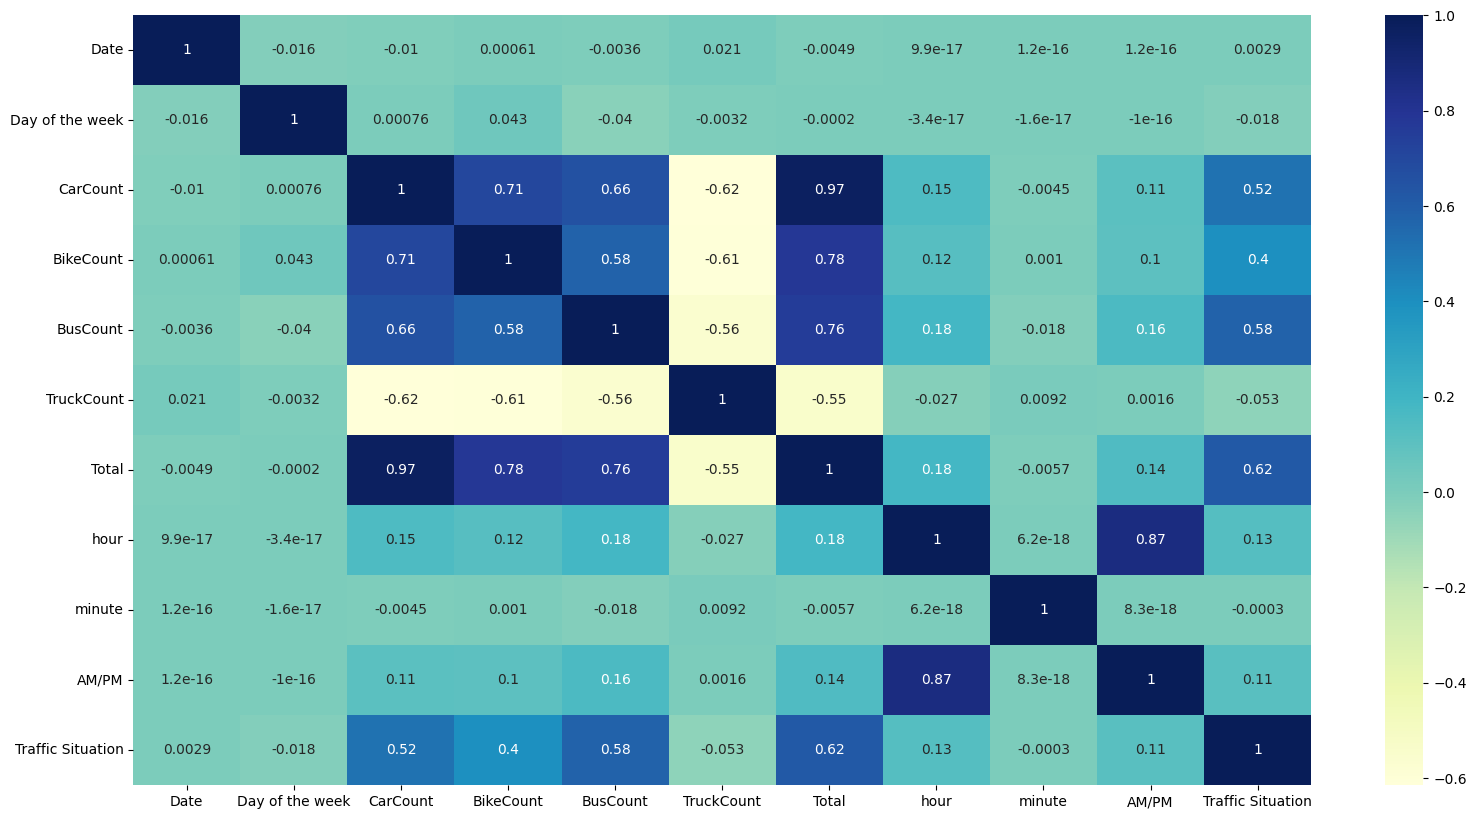

In [55]:
plt.figure(figsize = (19,10))
sns.heatmap(data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
           'TruckCount', 'Total', 'hour', 'minute', 'AM/PM', 'Traffic Situation']].corr(),
            cmap="YlGnBu",annot=True)

# Splitting Data

In [56]:
data.columns

Index(['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total', 'Traffic Situation', 'hour', 'minute', 'AM/PM'],
      dtype='object')

In [57]:
X= data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
       'TruckCount', 'Total','hour', 'minute', 'AM/PM']]

y= data['Traffic Situation'].values

In [58]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2 , random_state = 0)

# Feature Scaling

In [59]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_X = sc.fit_transform(train_X)
test_X = sc.transform(test_X)

# Model Selection using Voting Classifier üíª

In [60]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [61]:
cl1 = LogisticRegression()
cl2 = RandomForestClassifier()
cl3 = SVC(probability=True)
cl4 = XGBClassifier()
cl5 = AdaBoostClassifier()

voting_cl = VotingClassifier(estimators = [('lr',cl1),('rf',cl2),('svc',cl3),
                                          ('xgb',cl4),('ada',cl5)], voting = 'hard')

voting_cl.fit(train_X, train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('ada', AdaBoostClassifier())])

In [62]:
voting_pred = voting_cl.predict(test_X)

accuracy = accuracy_score(test_y, voting_pred)

In [63]:
accuracy

0.984047019311503

In [64]:
#Voting classfier using Cross_validation
for clf, label in zip([cl1,cl2,cl3,cl4,cl5],['lr','rf','svc','xgb','ada']):
    scores = cross_val_score(clf, train_X, train_y, scoring='accuracy', cv=5)
    print('Accuracy: ', (scores.mean(), label))

Accuracy:  (0.8832162035853166, 'lr')
Accuracy:  (0.9964287918735174, 'rf')
Accuracy:  (0.9308955796379413, 'svc')
Accuracy:  (0.9993697478991596, 'xgb')


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Accuracy:  (0.806752669588297, 'ada')


* **RandomForest** accuracy: **99.4%**
* **XgBoost** accuracy: **99.8%**

In [65]:
#Solo RandomForest Accuracy
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(train_X, train_y)

rfc_pred = rfc.predict(test_X)
accuracy = accuracy_score(test_y, rfc_pred)
accuracy

0.9974811083123426

In [66]:
#Solo Xgboost Accuracy
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(train_X, train_y)

xgbc_pred = xgbc.predict(test_X)
accuracy = accuracy_score(test_y, xgbc_pred)
accuracy

0.9991603694374476

* XGBoost Model isgiving 100% accuracy.
* It can be a sign of potential overfitting.
* Checking the model with cross_validation

# Confusion Matrix

In [67]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(test_y, xgbc_pred)
conf_matrix

array([[162,   0,   0,   0],
       [  0, 739,   0,   1],
       [  0,   0, 219,   0],
       [  0,   0,   0,  70]])

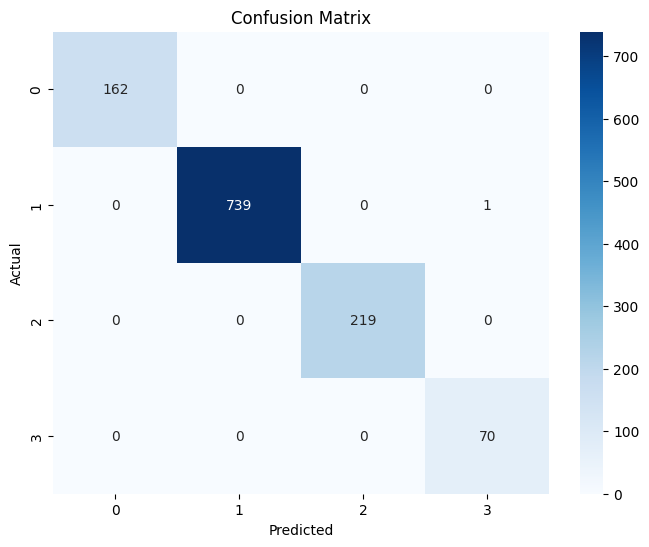

In [68]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()